# Run through one sequence, use the sequence class

In [1]:
!mkdir -p /scratch/aneesh

In [2]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "Grounded-Segment-Anything"))
sys.path.append(os.path.join(os.getcwd(), "Grounded-Segment-Anything", "GroundingDINO"))
sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
sys.path.append(os.path.join(os.getcwd(), "recognize-anything"))

print(os.getcwd(), os.path.join(os.getcwd(), "Grounded-Segment-Anything", "GroundingDINO"))
print(sys.path)

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# recognise anything
from ram.models import ram
from ram import inference_ram as inference
from ram import get_transform

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

import os

/home2/aneesh.chavan/Change_detection /home2/aneesh.chavan/Change_detection/Grounded-Segment-Anything/GroundingDINO
['/home2/aneesh.chavan/Change_detection', '/home2/aneesh.chavan/miniconda3/envs/reid/lib/python310.zip', '/home2/aneesh.chavan/miniconda3/envs/reid/lib/python3.10', '/home2/aneesh.chavan/miniconda3/envs/reid/lib/python3.10/lib-dynload', '', '/home2/aneesh.chavan/miniconda3/envs/reid/lib/python3.10/site-packages', '/home2/aneesh.chavan/Change_detection/recognize-anything', '/home2/aneesh.chavan/Change_detection/Grounded-Segment-Anything', '/home2/aneesh.chavan/Change_detection/Grounded-Segment-Anything/GroundingDINO', '/home2/aneesh.chavan/Change_detection/GroundingDINO', '/home2/aneesh.chavan/Change_detection/recognize-anything']


In [3]:
# load models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [7]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home2/aneesh.chavan/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


In [8]:
import os

# if not os.path.isfile("/scratch/aneesh/ram_swin_large_14m.pth"):
# !wget -O /scratch/aneesh/ram_swin_large_14m.pth https://huggingface.co/spaces/xinyu1205/recognize-anything/resolve/main/ram_swin_large_14m.pth

# r = ram(image_size=384, vit='swin_l')
ram_model = ram(pretrained='/scratch/aneesh/ram_swin_large_14m.pth', image_size=384, vit='swin_l')
# ram_model.eval()
# ram_model.to(device)

: 

: 

In [7]:
import matplotlib.pyplot as plt

test_img_path = '/home2/aneesh.chavan/Change_detection/360_zip/view2/view2.png'
transform = get_transform(image_size=384)
image = transform(Image.open(test_img_path)).unsqueeze(0).to(device)

res = inference(image, ram_model)
print("Image Tags: ", res[0])

plt.imshow(Image.open(test_img_path));


NameError: name 'ram_model' is not defined

In [4]:
! wget -O /scratch/aneesh/sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = '/scratch/aneesh/sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2024-01-24 22:21:01--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.12.124, 52.84.12.55, 52.84.12.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.12.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘/scratch/aneesh/sam_vit_h_4b8939.pth’

/scratch/aneesh/sam 100%[===================>]   2.39G  45.0MB/s    in 55s     

2024-01-24 22:21:58 (44.5 MB/s) - ‘/scratch/aneesh/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



### Grounding DINO for detection

In [17]:
# detect object using grounding DINO
def detect(image, text_prompt, model, image_source=None, box_threshold = 0.3, text_threshold = 0.25, remove_combined=False):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=0.35,
      text_threshold=text_threshold
  )

  if type(image_source) == None:
    annotated_frame = None
  else:
    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    annotated_frame = annotated_frame[...,::-1] # BGR to RGB

  return annotated_frame, boxes

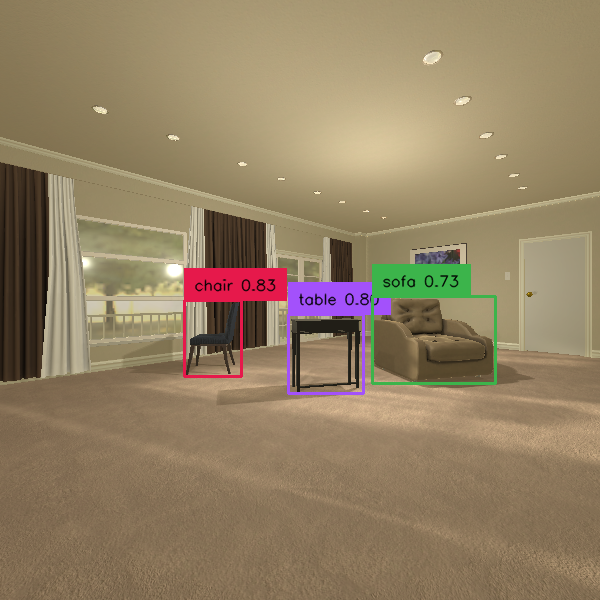

In [16]:
# download_image(image_url, local_image_path)
test_img_path = '/home2/aneesh.chavan/Change_detection/360_zip/view2/view2.png'
image_source, image = load_image(test_img_path)
Image.fromarray(image_source)

annotated_frame, detected_boxes = detect(image, text_prompt="sofa . chair . table",
                                         model=groundingdino_model,
                                         image_source=image_source)
Image.fromarray(annotated_frame)

In [28]:
# object retrieval functions

# return a tensor containing all bounding boxes
# filter for duplicates by calculating

# [TODO] speedup

import time

def getIoU(rect1, rect2):
  area_rect1 = rect1[2]*rect1[3]
  area_rect2 = rect2[2]*rect2[3]

  overlap_top_left = (max(rect1[0], rect2[0]), max(rect1[1], rect2[1]))
  overlap_bottom_right = (min(rect1[0] + rect1[2], rect2[0] + rect2[2]), min(rect1[1] + rect1[3], rect2[1] + rect2[3]))

  if (overlap_bottom_right[0] <= overlap_top_left[0]) or (overlap_bottom_right[1] <= overlap_top_left[1]):
    return 0.0  # No overlap, return 0% overlap

  # Calculate the area of the overlap rectangle
  overlap_area = abs((overlap_bottom_right[0] - overlap_top_left[0]) * (overlap_bottom_right[1] - overlap_top_left[1]))
  percent_overlap = (overlap_area / min(area_rect1, area_rect2))

  return percent_overlap

def compSize(rect1, rect2):
  area_rect1 = rect1[2]*rect1[3]
  area_rect2 = rect2[2]*rect2[3]

  diff = min(area_rect1, area_rect2)/max(area_rect1, area_rect2)
  return diff

def getAllDetectedBoxes(image, image_source=None, keywords=[], show=False, intersection_threshold=0.7, size_threshold=0.75):
  total_time = 0

  with torch.no_grad():
    boxes = []
    unique_boxes_num = 0

    for i, word in enumerate(keywords):
      af, detected = detect(image, image_source=image_source, text_prompt=str(word), model=groundingdino_model)

      cnt_time = time.time()

      # # limit edges
      # for d in detected:
      #   if d[0] + d[2] >= 1:
      #     d[2] = 1 - d[0]

      #   if d[1] + d[3] >= 1:
      #     d[3] = 1 - d[1]

      if show:
        print(i)
      unique_enough = True

      if detected != None and len(detected) != 0:
        if unique_boxes_num == 0:
          for box in detected:
            boxes.append(box)
            unique_boxes_num += 1

          if show and type(image_source) != None:
            Image.fromarray(af).show()

            if show:
              print("detected", detected)

        else:
          print("boxes: ", boxes)
          for box in detected:
            unique_enough = True

            if show:
              print("detected: ", detected)

            for prev in boxes[:unique_boxes_num]:

              iou = getIoU(box, prev)
              diff = compSize(box, prev)

              if show:
                print("comparing; -- ", prev, box)
                print("iou: ", iou)
                print("diff: ", diff)

              if (iou > intersection_threshold and diff > size_threshold):
                # bounding box is not unique enough to be added
                unique_enough = False

                if show:
                  print("failed")
                break

            if unique_enough:
              boxes.append(box)
              unique_boxes_num += 1

              if show:
                print("         success!")
                print(boxes)

          if show and type(image_source) != None:
            plt.imshow(af)

      total_time += (time.time() - cnt_time)

    print(total_time)
    return torch.stack(boxes)
  
def decide_uniqueness(candidate_boxes, stored_boxes, intersection_threshold=0.7, size_threshold=0.75):
  # get area difference
  candidate_areas = 4 * candidate_boxes[:,2] * candidate_boxes[:,3]
  stored_areas = 4 * stored_boxes[:,2] * stored_boxes[:,3]
  minimum_areas = np.minimum(candidate_areas.unsqueeze(1), stored_areas)

  area_diff = candidate_areas.unsqueeze(1)/stored_areas
  area_diff[area_diff >= 1.] = 1/area_diff[area_diff >= 1.]

  conv_cb = candidate_boxes.clone()
  conv_sb = stored_boxes.clone()

  conv_cb[:, :2] -= conv_cb[:, 2:]
  conv_cb[:, 2:] = 2 * conv_cb[:, 2:] + conv_cb[:, :2]
  conv_cb = np.expand_dims(conv_cb, axis=1)

  conv_sb[:, :2] -= conv_sb[:, 2:]
  conv_sb[:, 2:] = 2 * conv_sb[:, 2:] + conv_sb[:, :2]

  overlap_boxes = np.concatenate([np.maximum(conv_cb[...,:2], conv_sb[...,:2]),
                                  np.minimum(conv_cb[...,2:], conv_sb[...,2:])],
                                 axis=-1)

  iou = np.where(np.logical_and((overlap_boxes[..., 2] > overlap_boxes[..., 0]), (overlap_boxes[..., 3] > overlap_boxes[..., 1])),
                 (overlap_boxes[..., 3] - overlap_boxes[..., 1]) * (overlap_boxes[..., 2] - overlap_boxes[..., 0])/minimum_areas,
                 -np.inf)

  boxes_comparison = np.where(
      np.logical_and(np.logical_and(iou > intersection_threshold, area_diff > size_threshold), iou != -np.inf),
      False,
      True
  )

  unique_enough = np.logical_and.reduce(boxes_comparison, 1)

  return unique_enough

def eff_getAllDetectedBoxes(image, image_source=None, keywords=[], show=False, intersection_threshold=0.7, size_threshold=0.75):
  with torch.no_grad():
    boxes = None
    unique_boxes_num = 0

    total_time = 0

    for i, word in enumerate(keywords):
      af, detected = detect(image, image_source=image_source, text_prompt=str(word), model=groundingdino_model)

      cnt_time = time.time()

      if show:
        print(i)
      # unique_enough = True

      # sort through all detected boxes, add them if there is little enough overlap with all recorded bboxes, or it is small enough for overlap to not matter
      if detected != None and len(detected) != 0:
        if boxes == None:
          boxes = detected

          if show and type(image_source) != None:
            Image.fromarray(af).show()

            if show:
              print("detected", detected)

        else:
          if show:
            print("boxes:\n", boxes)

            if type(image_source) != None:
              Image.fromarray(af).show()


          unique_enough = decide_uniqueness(detected, boxes)
          boxes = torch.concat([boxes] + [detected[num].unsqueeze(0) for num, val in enumerate(unique_enough) if val])

          if show:
            for i, k in enumerate(unique_enough):
              print("Added " if k else "Failed ", sep='')
              print(detected[i])


          total_time += (time.time() - cnt_time)

    print(total_time)
    return boxes
  
# segmentation code

def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return boxes_xyxy, masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


In [21]:
%matplotlib inline

0
detected tensor([[0.7229, 0.5663, 0.2021, 0.1418],
        [0.3544, 0.5628, 0.0900, 0.1236]])
1
boxes:  [tensor([0.7229, 0.5663, 0.2021, 0.1418]), tensor([0.3544, 0.5628, 0.0900, 0.1236])]
detected:  tensor([[0.5001, 0.7803, 1.0000, 0.4384]])
comparing; --  tensor([0.7229, 0.5663, 0.2021, 0.1418]) tensor([0.5001, 0.7803, 1.0000, 0.4384])
iou:  0.0
diff:  tensor(0.0654)
comparing; --  tensor([0.3544, 0.5628, 0.0900, 0.1236]) tensor([0.5001, 0.7803, 1.0000, 0.4384])
iou:  0.0
diff:  tensor(0.0254)
         success!
[tensor([0.7229, 0.5663, 0.2021, 0.1418]), tensor([0.3544, 0.5628, 0.0900, 0.1236]), tensor([0.5001, 0.7803, 1.0000, 0.4384])]
Opening "/tmp/tmpxz5gltto.PNG" with Firefox Web Browser  (image/png)


Unable to init server: Broadway display type not supported: localhost:10.0
Error: cannot open display: localhost:10.0
Unable to init server: Broadway display type not supported: localhost:10.0
Error: cannot open display: localhost:10.0


2
boxes:  [tensor([0.7229, 0.5663, 0.2021, 0.1418]), tensor([0.3544, 0.5628, 0.0900, 0.1236]), tensor([0.5001, 0.7803, 1.0000, 0.4384])]
detected:  tensor([[0.5001, 0.1966, 1.0000, 0.3931]])
comparing; --  tensor([0.7229, 0.5663, 0.2021, 0.1418]) tensor([0.5001, 0.1966, 1.0000, 0.3931])
iou:  tensor(0.1652)
diff:  tensor(0.0729)
comparing; --  tensor([0.3544, 0.5628, 0.0900, 0.1236]) tensor([0.5001, 0.1966, 1.0000, 0.3931])
iou:  0.0
diff:  tensor(0.0283)
comparing; --  tensor([0.5001, 0.7803, 1.0000, 0.4384]) tensor([0.5001, 0.1966, 1.0000, 0.3931])
iou:  0.0
diff:  tensor(0.8966)
         success!
[tensor([0.7229, 0.5663, 0.2021, 0.1418]), tensor([0.3544, 0.5628, 0.0900, 0.1236]), tensor([0.5001, 0.7803, 1.0000, 0.4384]), tensor([0.5001, 0.1966, 1.0000, 0.3931])]
3
boxes:  [tensor([0.7229, 0.5663, 0.2021, 0.1418]), tensor([0.3544, 0.5628, 0.0900, 0.1236]), tensor([0.5001, 0.7803, 1.0000, 0.4384]), tensor([0.5001, 0.1966, 1.0000, 0.3931])]
detected:  tensor([[0.3544, 0.5629, 0.0894, 0

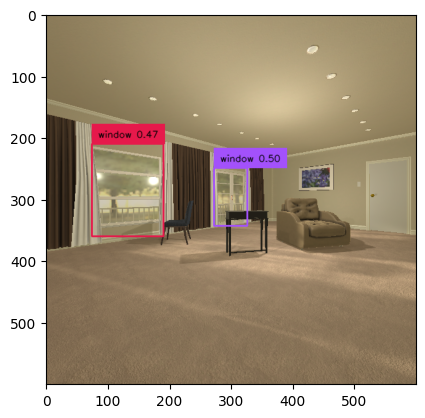

In [29]:
detected_boxes = getAllDetectedBoxes(image, image_source, [l for l in [""]],
                                     show=False)

In [ ]:
bboxs, segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)

for idx in range(segmented_frame_masks.shape[0]):
  annotated_frame_with_mask = draw_mask(segmented_frame_masks[idx][0], annotated_frame)
  plt.figure()
  plt.imshow(annotated_frame_with_mask)
#   Image.fromarray(annotated_frame_with_mask).show()